In [1]:
from dataset import DataSet
import matplotlib.pyplot as plt
import epyestim
import epyestim.covid19 as covid19

In [2]:
dataset = DataSet('dati-regioni/dpc-covid19-ita-regioni.csv')
dataset

DataSet
  repo: pcm-dpc/COVID-19
  path: dati-regioni/dpc-covid19-ita-regioni.csv
  commit_url: https://api.github.com/repos/pcm-dpc/COVID-19/commits?path=dati-regioni/dpc-covid19-ita-regioni.csv&page=1&per_page=1
  last_modified: 2021-02-07 16:57:13+01:00
  data_url: https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv
  df: 7350 items

In [3]:
def region_df(dataset, region, resample=True):
    df = dataset.df[dataset.df['denominazione_regione'] == region]
    if resample:
        df = df.resample('D').last()
    return df

lombardia = region_df(dataset, 'Lombardia')
lombardia['nuovi_positivi']

data
2020-02-24     166
2020-02-25      68
2020-02-26      18
2020-02-27     145
2020-02-28     128
              ... 
2021-02-03    1738
2021-02-04    1746
2021-02-05    2504
2021-02-06    1923
2021-02-07    1515
Freq: D, Name: nuovi_positivi, Length: 350, dtype: int64

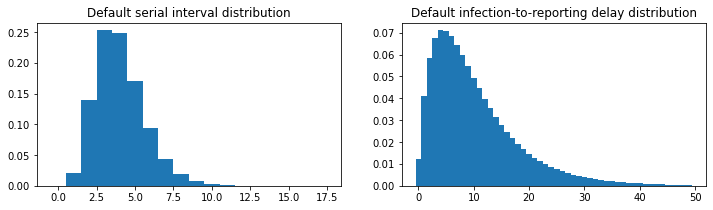

In [4]:
si_distrb = covid19.generate_standard_si_distribution()
delay_distrb = covid19.generate_standard_infection_to_reporting_distribution()

fig, axs = plt.subplots(1, 2, figsize=(12,3))

axs[0].set_title('Default serial interval distribution')
axs[0].bar(range(len(si_distrb)), si_distrb, width=1)

axs[1].set_title('Default infection-to-reporting delay distribution')
axs[1].bar(range(50), delay_distrb[:50], width=1)

plt.show()

In [5]:
# from scipy.stats import gamma
# lomb_cont_distrb = gamma(a=1.87, scale=0.28)
# lomb_delay_distrb = epyestim.discrete_distrb(lomb_cont_distrb)

# plt.bar(range(len(death_delay_distrb)), death_delay_distrb, width=1)
# plt.show()

In [6]:
# death_dist_cont = gamma(a=16, scale=1)
# death_dist = epyestim.discrete_distrb(death_dist_cont)

In [7]:
def show_series_r(time_varying_r, name, xlim=None, figsize=(16, 8)):
    fig, ax = plt.subplots(1,1, figsize=figsize)
    time_varying_r.loc[:,'Q0.5'].plot(ax=ax, color='red')
    ax.fill_between(time_varying_r.index, 
                    time_varying_r['Q0.025'], 
                    time_varying_r['Q0.975'], 
                    color='red', alpha=0.2)
    ax.set_xlabel('date')
    ax.set_ylabel('R(t) with 95%-CI')
    ax.set_ylim([0,3])
    ax.axhline(y=1)
    ax.axhline(y=1.25, ls='--')
    ax.set_title(f'Estimate of time-varying effective reproduction number for {name}')
    if xlim:
        ax.set_xlim(xlim)
    plt.show()

def show_region_r(dataset, region, column='nuovi_positivi', cumsum=False,
                  smoothing_window=None, r_window_size=None, 
                  si_distrb = covid19.generate_standard_si_distribution(),
                  delay_distrb = covid19.generate_standard_infection_to_reporting_distribution(),
                  figsize=(16, 8), xlim=None):
    df = region_df(dataset, region)
    kwargs = {}
    if smoothing_window:
        kwargs['smoothing_window'] = smoothing_window
    if r_window_size:
        kwargs['r_window_size'] = r_window_size
    kwargs['gt_distribution'] = si_distrb
    kwargs['delay_distribution'] = delay_distrb
    series = df[column]
    if cumsum:
        series = series.cumsum()
    time_varying_r = covid19.r_covid(series, **kwargs)
    show_series_r(time_varying_r, region, xlim=xlim, figsize=figsize)
    return time_varying_r

In [8]:
dataset.df['denominazione_regione'].unique()

array(['Abruzzo', 'Basilicata', 'Calabria', 'Campania', 'Emilia-Romagna',
       'Friuli Venezia Giulia', 'Lazio', 'Liguria', 'Lombardia', 'Marche',
       'Molise', 'P.A. Bolzano', 'P.A. Trento', 'Piemonte', 'Puglia',
       'Sardegna', 'Sicilia', 'Toscana', 'Umbria', "Valle d'Aosta",
       'Veneto'], dtype=object)

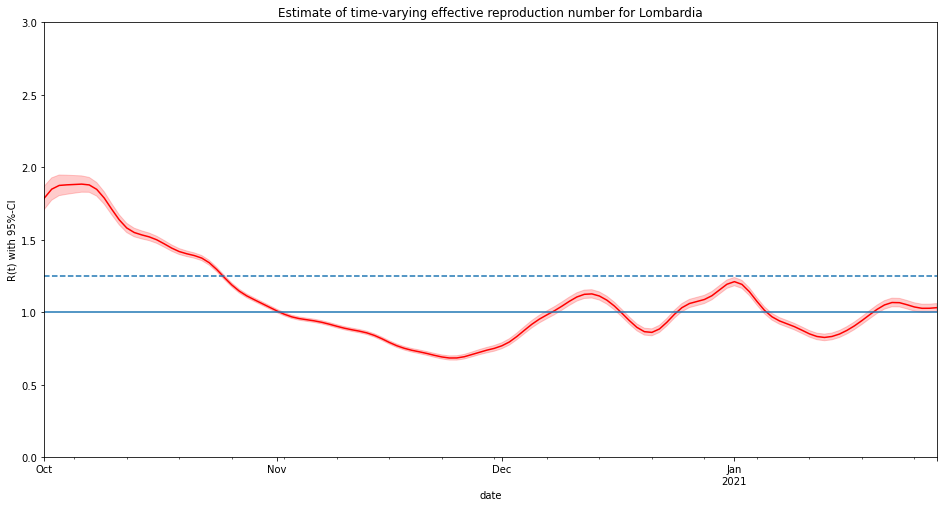

,cases,R_mean,R_var,Q0.025,Q0.5,Q0.975
2020-02-29,84.0,2.399738,0.002385,2.304857,2.399403,2.496861
2020-03-01,369.0,1.947176,0.001416,1.874102,1.946936,2.021710
2020-03-02,270.0,1.708465,0.000986,1.647502,1.708273,1.770402
2020-03-03,266.0,1.597828,0.000773,1.543858,1.597667,1.652945
2020-03-04,300.0,1.561144,0.000657,1.511520,1.561005,1.611558
...,...,...,...,...,...,...
2021-01-24,1375.0,1.051966,0.000220,1.023021,1.051896,1.081310
2021-01-25,1484.0,1.036262,0.000214,1.007860,1.036193,1.065030
2021-01-26,1230.0,1.027155,0.000209,0.999064,1.027088,1.055590
2021-01-27,2293.0,1.027468,0.000207,0.999469,1.027400,1.055842


In [9]:
show_region_r(dataset, 'Lombardia', xlim=('2020-10-01', None))

In [10]:
# show_region_r(dataset, 'Lombardia',
#               delay_distrb=lomb_delay_distrb,
#               smoothing_window=14, r_window_size=7, 
#               xlim=('2020-10-01', None))

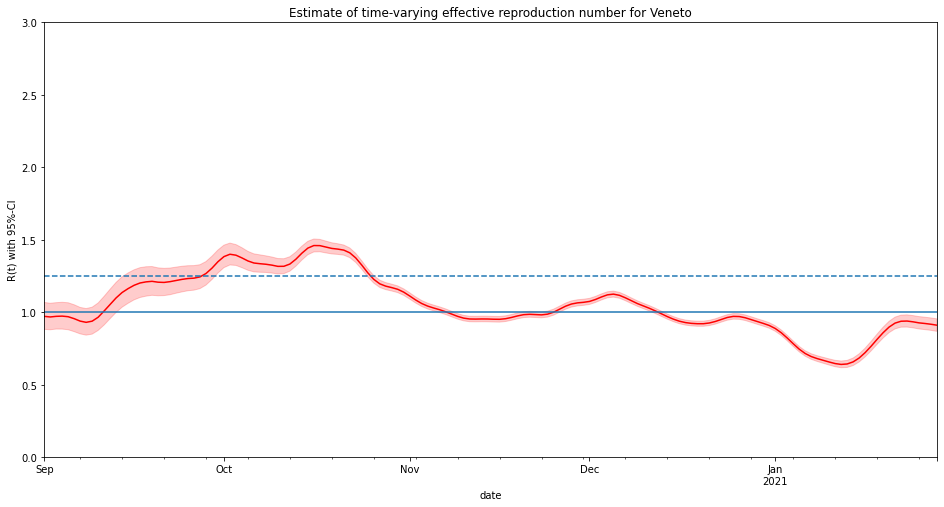

,cases,R_mean,R_var,Q0.025,Q0.5,Q0.975
2020-02-29,40.0,1.873205,0.011534,1.669100,1.871098,2.091493
2020-03-01,72.0,1.734922,0.008818,1.553858,1.733280,1.925356
2020-03-02,10.0,1.676209,0.007265,1.513446,1.674754,1.847008
2020-03-03,34.0,1.695671,0.006375,1.542033,1.694408,1.855205
2020-03-04,53.0,1.763447,0.005802,1.616353,1.762369,1.915766
...,...,...,...,...,...,...
2021-01-24,956.0,0.934048,0.000466,0.892273,0.933880,0.976772
2021-01-25,533.0,0.926867,0.000470,0.884753,0.926697,0.969933
2021-01-26,746.0,0.922510,0.000474,0.880026,0.922336,0.965530
2021-01-27,2385.0,0.917295,0.000479,0.875081,0.917123,0.960594


In [11]:
show_region_r(dataset, 'Veneto', xlim=('2020-09-01', None))

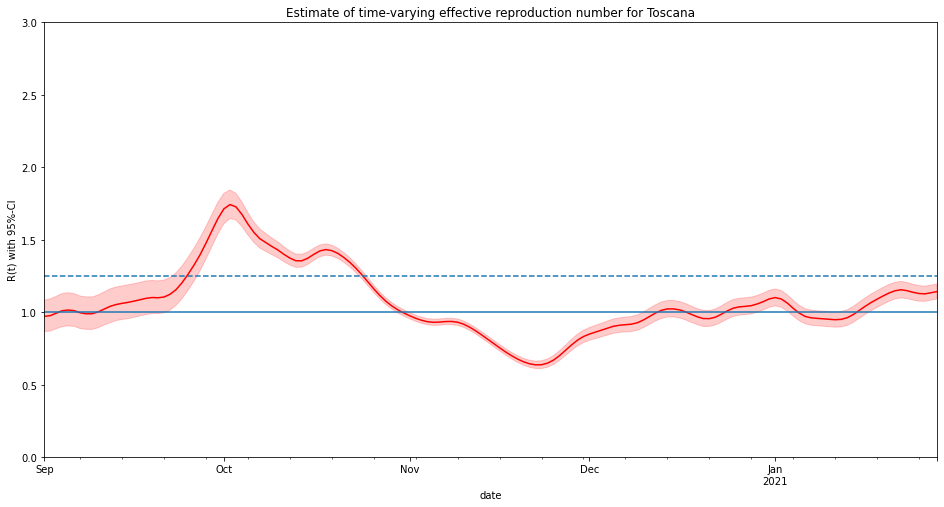

,cases,R_mean,R_var,Q0.025,Q0.5,Q0.975
2020-03-01,2.0,3.001320,0.071540,2.502482,2.993784,3.548279
2020-03-02,0.0,2.439994,0.040779,2.067173,2.434397,2.854567
2020-03-03,6.0,2.183056,0.027665,1.869681,2.178883,2.521676
2020-03-04,19.0,2.103887,0.021144,1.829381,2.100694,2.395266
2020-03-05,23.0,2.086351,0.017118,1.840580,2.083735,2.350051
...,...,...,...,...,...,...
2021-01-24,526.0,1.137670,0.000768,1.084166,1.137446,1.192643
2021-01-25,422.0,1.129312,0.000740,1.076458,1.129092,1.183333
2021-01-26,346.0,1.127130,0.000715,1.075357,1.126919,1.180104
2021-01-27,502.0,1.134904,0.000696,1.083728,1.134702,1.186979


In [12]:
show_region_r(dataset, 'Toscana', xlim=('2020-09-01', None))

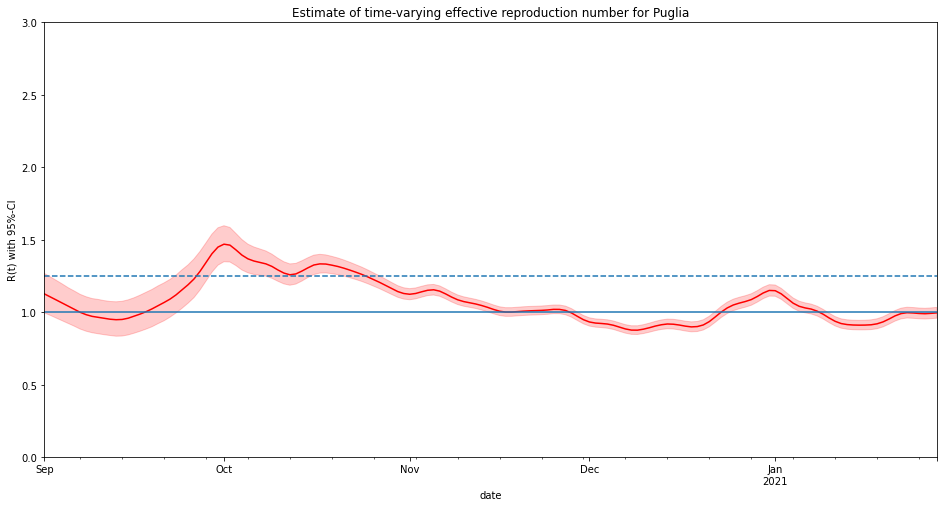

,cases,R_mean,R_var,Q0.025,Q0.5,Q0.975
2020-03-05,5.0,2.381284,0.076914,1.869692,2.370093,2.958351
2020-03-06,3.0,2.360606,0.060343,1.897353,2.351787,2.873891
2020-03-07,9.0,2.318976,0.047569,1.903988,2.312279,2.761084
2020-03-08,14.0,2.259825,0.037693,1.887495,2.254273,2.654131
2020-03-09,10.0,2.182731,0.029258,1.862226,2.178232,2.533559
...,...,...,...,...,...,...
2021-01-24,954.0,0.994997,0.000359,0.958092,0.994877,1.032460
2021-01-25,401.0,0.991662,0.000358,0.954918,0.991542,1.029059
2021-01-26,995.0,0.989935,0.000358,0.953248,0.989815,1.027260
2021-01-27,1233.0,0.992466,0.000360,0.955761,0.992346,1.029847


In [14]:
show_region_r(dataset, 'Puglia', xlim=('2020-09-01', None))

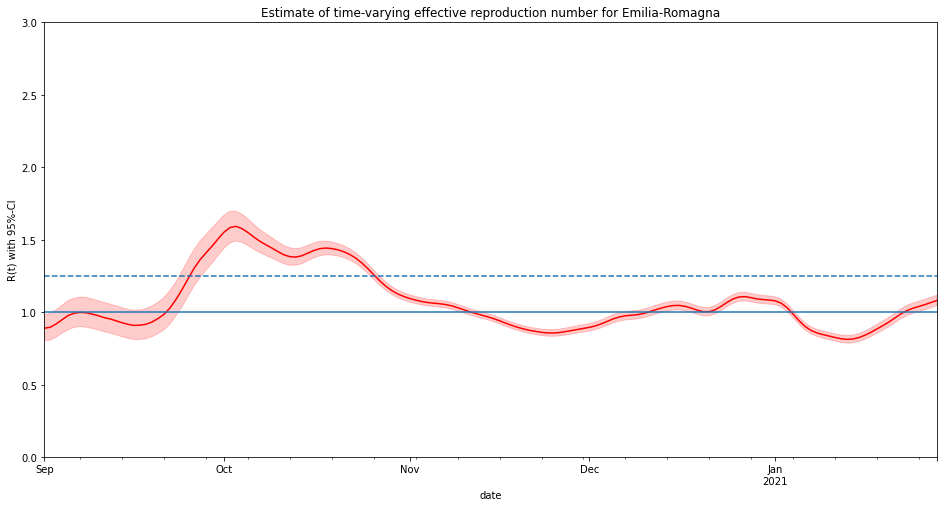

,cases,R_mean,R_var,Q0.025,Q0.5,Q0.975
2020-02-29,72.0,1.871218,0.006146,1.721549,1.870161,2.027321
2020-03-01,68.0,1.634999,0.004382,1.508075,1.634111,1.767767
2020-03-02,50.0,1.505546,0.003444,1.394070,1.504778,1.623741
2020-03-03,85.0,1.449638,0.002913,1.346327,1.448965,1.558351
2020-03-04,124.0,1.449024,0.002597,1.351145,1.448435,1.550673
...,...,...,...,...,...,...
2021-01-24,1208.0,1.027968,0.000329,0.992768,1.027863,1.063726
2021-01-25,1164.0,1.040365,0.000332,1.004933,1.040259,1.076395
2021-01-26,993.0,1.052975,0.000334,1.017449,1.052869,1.089023
2021-01-27,923.0,1.067041,0.000335,1.031463,1.066937,1.103215


In [16]:
show_region_r(dataset, 'Emilia-Romagna', xlim=('2020-09-01', None))